# Библиотеки

In [1]:
import contractions as contractions
# Импорт библиотек
import pandas as pd
from datasets import load_dataset

# текстовая предобработка
import emoji
import re
import contractions
import nltk
from nltk.corpus import stopwords
from natasha import MorphVocab

# визуализация
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from collections import Counter
from spacy.lang.ru.stop_words import STOP_WORDS


# Загрузка данных

In [2]:
# Загрузка данных
raw_dataset = load_dataset("seara/ru_go_emotions", name="raw")
print(raw_dataset)
# Извлечение тренировочных, тестовых и валидационных данных
data=raw_dataset['train']
#train_data = simplified_dataset['train']
#test_data = simplified_dataset['test']
#validation_data = simplified_dataset['validation']

DatasetDict({
    train: Dataset({
        features: ['ru_text', 'text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
        num_rows: 211225
    })
})


In [3]:
# Создание DataFrame
df_train = pd.DataFrame.from_dict(data)

# Удаление ненужных столбцов
df_train = df_train.drop('text', axis=1).drop('id', axis=1).drop('author', axis=1).drop('subreddit', axis=1).drop('link_id', axis=1).drop('parent_id', axis=1).drop('created_utc', axis=1).drop('rater_id', axis=1).drop('example_very_unclear', axis=1)

# Проверка на тренировочном наборе
df_train.head(n=5)

ru_text  admiration  amusement  \
0                       Эта игра причинила мне боль.           0          0   
1  >сексуальность не должна быть групповой катего...           0          0   
2  Ты правильно поступаешь, если тебе все равно, ...           0          0   
3                            Чувак, я обожаю Reddit.           0          0   
4  [ИМЯ] не было рядом с ними, он был рядом с «Со...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      0          0         0       0          0          0       0  ...   
1      0          0         0       0          0          0       0  ...   
2      0          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          0         0       0          0          0       0  ...   

   love  nervousness  optimism  pride  realization  relief  remorse  sadness  \
0     0            0         0      0            0       0        0        1   
1     0            0         0      0            0       0        0        0   
2     0            0         0      0            0       0        0        0   
3     1            0         0      0            0       0        0        0   
4     0            0         0      0            0       0        0        0   

   surprise  neutral  
0         0        0  
1         0        0  
2         0        1  
3         0        0  
4         0        1  

[5 rows x 29 columns]

In [4]:
# Создадим столбец с названием эмоции
df_train['labels'] = df_train.apply(lambda row: ', '.join([col for col in df_train.columns[1:] if row[col] == 1]), axis=1)
# Замените labels на 'not_detect', если все значения равны 0
df_train['labels'] = df_train.apply(lambda row: 'not_detect' if row['labels'] == '' else row['labels'], axis=1)


In [5]:
df_train.head()

ru_text  admiration  amusement  \
0                       Эта игра причинила мне боль.           0          0   
1  >сексуальность не должна быть групповой катего...           0          0   
2  Ты правильно поступаешь, если тебе все равно, ...           0          0   
3                            Чувак, я обожаю Reddit.           0          0   
4  [ИМЯ] не было рядом с ними, он был рядом с «Со...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      0          0         0       0          0          0       0  ...   
1      0          0         0       0          0          0       0  ...   
2      0          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          0         0       0          0          0       0  ...   

   nervousness  optimism  pride  realization  relief  remorse  sadness  \
0            0         0      0            0       0        0        1   
1            0         0      0            0       0        0        0   
2            0         0      0            0       0        0        0   
3            0         0      0            0       0        0        0   
4            0         0      0            0       0        0        0   

   surprise  neutral      labels  
0         0        0     sadness  
1         0        0  not_detect  
2         0        1     neutral  
3         0        0        love  
4         0        1     neutral  

[5 rows x 30 columns]

In [6]:
# подсчет строк где нет информации об эмоциях
df_train[df_train['labels'] == 'not_detect'].shape[0]

3411

In [7]:
# удалить эти строки
df_train = df_train[df_train['labels'] != 'not_detect']
# и перепроверить
df_train[df_train['labels'] == 'not_detect'].shape[0]


0

In [8]:
# Определение количества примеров в тренировочном наборе данных
dfsize_train = df_train.shape[0]

# Форма тренировочного, валидационного и тестового наборов данных
print("Тренировочный набор данных содержит {} примеров".format(dfsize_train))

Тренировочный набор данных содержит 207814 примеров


# Предобработка текста (столбец ru_text)

In [9]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
stop_words_russian = set(stopwords.words('russian'))

# Дополнительные стоп-слова
custom_stop_words = {'имя', 'ИМЯ'}

# Инициализация морфологического словаря
morph_vocab = MorphVocab()

# Функция предобработки текста
def preprocess_text(x):

  # Добавление пробела между словами и знаками препинания
  x = re.sub(r'([а-яА-Я\[\]])([,;.!?])', r'\1 \2', x)
  x = re.sub(r'([,;.!?])([а-яА-Я\[\]])', r'\1 \2', x)

  # Нижний регистр
  x = x.lower()

  # Убираем смайлы
  x = emoji.demojize(x)

  # Расщирение сокращений
  x = contractions.fix(x)

  # Обработка смайлов
  x = re.sub(r"<3", "любовь", x)
  x = re.sub(r"xd", " улыбающееся лицо с открытым ртом и плотно закрытыми глазами ", x)
  x = re.sub(r":\)", " улыбающееся лицо ", x)
  x = re.sub(r"^_^", " улыбающееся лицо ", x)
  x = re.sub(r"\*_\*", "звезы в глазах", x)
  x = re.sub(r":\(", "хмурое лицо", x)
  x = re.sub(r":\^\(", "хмурое лицо", x)
  x = re.sub(r";\(", "хмурое лицо", x)
  x = re.sub(r":\/", "конфуз", x)
  x = re.sub(r";\)", " подмигивание", x)
  x = re.sub(r">__<", "неинтересно", x)
  x = re.sub(r"\b([xo]+x*)\b", "xoxo", x)
  x = re.sub(r"\b(n+a+h+)\b", "нет", x)

  # Обработка спецсимволов, пробелов итд
  x = re.sub(r"\b([.]{3,})"," dots ", x)
  x = re.sub(r"[^А-Яа-яA-Za-z!?_]+", " ", x)
  x = re.sub(r"\b([s])\b *","", x)

  # Лемматизация
  x = ' '.join([morph_vocab.parse(word)[0].normal_form for word in x.split()])

  # Удаление стоп-слов
  x = ' '.join([word for word in x.split() if word.lower() not in stop_words_russian and word not in custom_stop_words])

  # Удаление знаков препинания
  x = re.sub(r"[,.;!?]", "", x)

  x = re.sub(r" +"," ", x)
  x = x.strip()

  return x

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abalashov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Применение обработки к датасету
df_train["ru_text_clean"] = df_train["ru_text"].apply(preprocess_text)

# Превью обработки на примере датачета обучения
display(df_train[['ru_text', 'ru_text_clean']].sample(5))
print(df_train.shape)

ru_text  \
158417                              Скучаю по рок фесту 😔   
20931   Есть зарождающаяся супермагистраль под названи...   
42532                     Мне нравится твой стиль письма!   
173468  Большое спасибо! Просто хотел быть готовым на ...   
151246                                Ну ладно, заткнись!   

                                            ru_text_clean  
158417                      скучать рок фест pensive_face  
20931   зарождаться супермагистраль название межштатны...  
42532                         нравиться твой стиль письмо  
173468   большой спасибо просто хотеть готовый случай ещё  
151246                                  ладный заткнуться

(207814, 31)


In [12]:
# Удалим все строки, где NaN (пустые) в столбце ru_text_clean
df_train = df_train.dropna(subset=['ru_text_clean'])
print(df_train.shape)

(207814, 31)


# Анализ и обработка эмоций

In [13]:
df_train['labels'].value_counts()

labels
neutral                                       55298
approval                                      11259
admiration                                    10531
annoyance                                      8342
disapproval                                    7686
                                              ...  
disgust, embarrassment, grief                     1
anger, remorse, sadness                           1
disappointment, disapproval, pride                1
disgust, nervousness, realization                 1
caring, desire, excitement, love, optimism        1
Name: count, Length: 2010, dtype: int64

In [14]:
# Загрузка списка эмоций для таксономии
with open("ru_emotions.txt", "r", encoding="utf-8") as file:
    taxonomy = dict(line.split(': ')
    for line in file.read().splitlines())

In [15]:
def map_to_russian(emotion):
    # Функция для отображения английских эмоций в русские
    return taxonomy.get(emotion, 'unknown')

# Добавление столбца ru_labels
df_train['ru_labels'] = df_train['labels'].apply(map_to_russian)


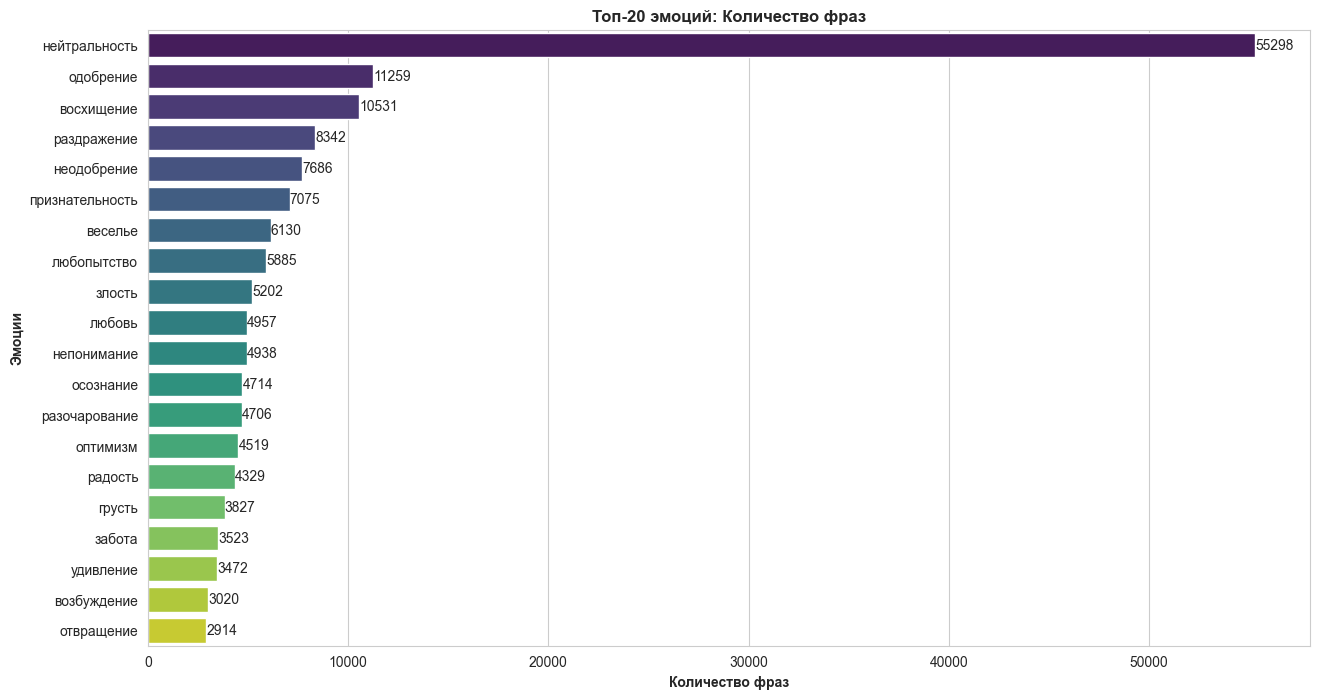

In [16]:
# Подсчет количества фраз для каждой комбинации эмоций, исключая "unknown"
emo_class_count = df_train[df_train["ru_labels"] != 'unknown']["ru_labels"].apply(lambda x: str(x)).value_counts()

# Подсчет количества фраз для каждой эмоции, исключая "unknown"
emotion_counts = df_train[df_train["ru_labels"] != 'unknown']["ru_labels"].value_counts().head(20)

# Визуализация
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=emotion_counts.values, y=emotion_counts.index, hue=emotion_counts.index, palette="viridis", dodge=False)

count_emo_by_class = 0
# Аннотации с количеством фраз
for p in ax.patches:
    value = int(p.get_width())
    x = p.get_x() + p.get_width() + 10
    y = p.get_y() + p.get_height() / 2
    if (count_emo_by_class < 20 ): plt.text(x, y, value, va='center', fontsize=10)
    count_emo_by_class = count_emo_by_class + 1

plt.title("Топ-20 эмоций: Количество фраз", fontweight='bold')
plt.xlabel("Количество фраз", fontweight='bold')
plt.ylabel("Эмоции", fontweight='bold')
plt.show()

In [17]:
# так как много нейтральных типов определения - то удалим их для повышения эффективности дальнейшнго обучения
df_train = df_train.drop(columns=['neutral'])


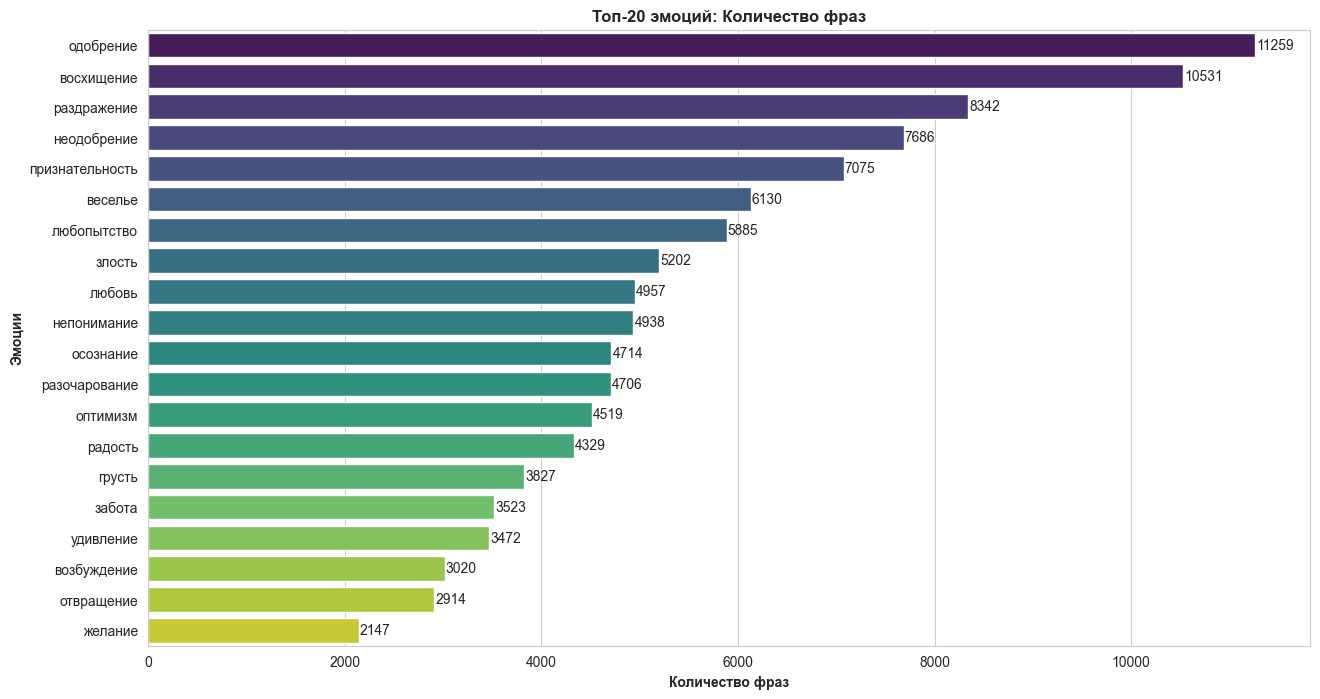

In [18]:
# Повторно посмотрим на ситуацию
# Подсчет количества фраз для каждой комбинации эмоций, исключая "unknown"
emo_class_count = df_train[(df_train["ru_labels"] != 'unknown') & (df_train["ru_labels"] != 'нейтральность')]["ru_labels"].apply(lambda x: str(x)).value_counts()

# Подсчет количества фраз для каждой эмоции, исключая "unknown"
emotion_counts = df_train[(df_train["ru_labels"] != 'unknown') & (df_train["ru_labels"] != 'нейтральность')]["ru_labels"].value_counts().head(20)

# Визуализация
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=emotion_counts.values, y=emotion_counts.index, hue=emotion_counts.index, palette="viridis", dodge=False)

count_emo_by_class = 0
# Аннотации с количеством фраз
for p in ax.patches:
    value = int(p.get_width())
    x = p.get_x() + p.get_width() + 10
    y = p.get_y() + p.get_height() / 2
    if (count_emo_by_class < 20 ): plt.text(x, y, value, va='center', fontsize=10)
    count_emo_by_class = count_emo_by_class + 1

plt.title("Топ-20 эмоций: Количество фраз", fontweight='bold')
plt.xlabel("Количество фраз", fontweight='bold')
plt.ylabel("Эмоции", fontweight='bold')
plt.show()

In [19]:
# Функция для отображения 10 самых часто встречающихся слов в наборе комментариев
def top10_words_in_class(text, axes, emotion_name):
    text = text.str.split()  # разбить каждый комментарий на список слов
    text = text.values.tolist()  # из серии pandas в списки слов
    corpus = [word for sample in text for word in sample if word not in list(STOP_WORDS) + ["?", "!", "имя", "ИМЯ"]]  # корпус слов, исключая спецсимволы
    counter = Counter(corpus)  # создать счетчик
    top10 = counter.most_common(10)  # получить 10 наиболее часто встречающихся слов

    # Построить диаграмму топ-10 слов и их частот
    top10 = [(word, count) for (word, count) in top10]
    x, y = zip(*top10)
    colors = sns.color_palette("husl", n_colors=len(x))

    for word, color in zip(x, colors):
        sns.barplot(x=[y[x.index(word)]], y=[word], ax=axes, color=color, dodge=False, legend=False)

    axes.set_title(f"Top 10 слов для эмоции '{emotion_name}'")
    axes.set_xlabel("Количество слов")
    axes.set_ylabel("Слова")

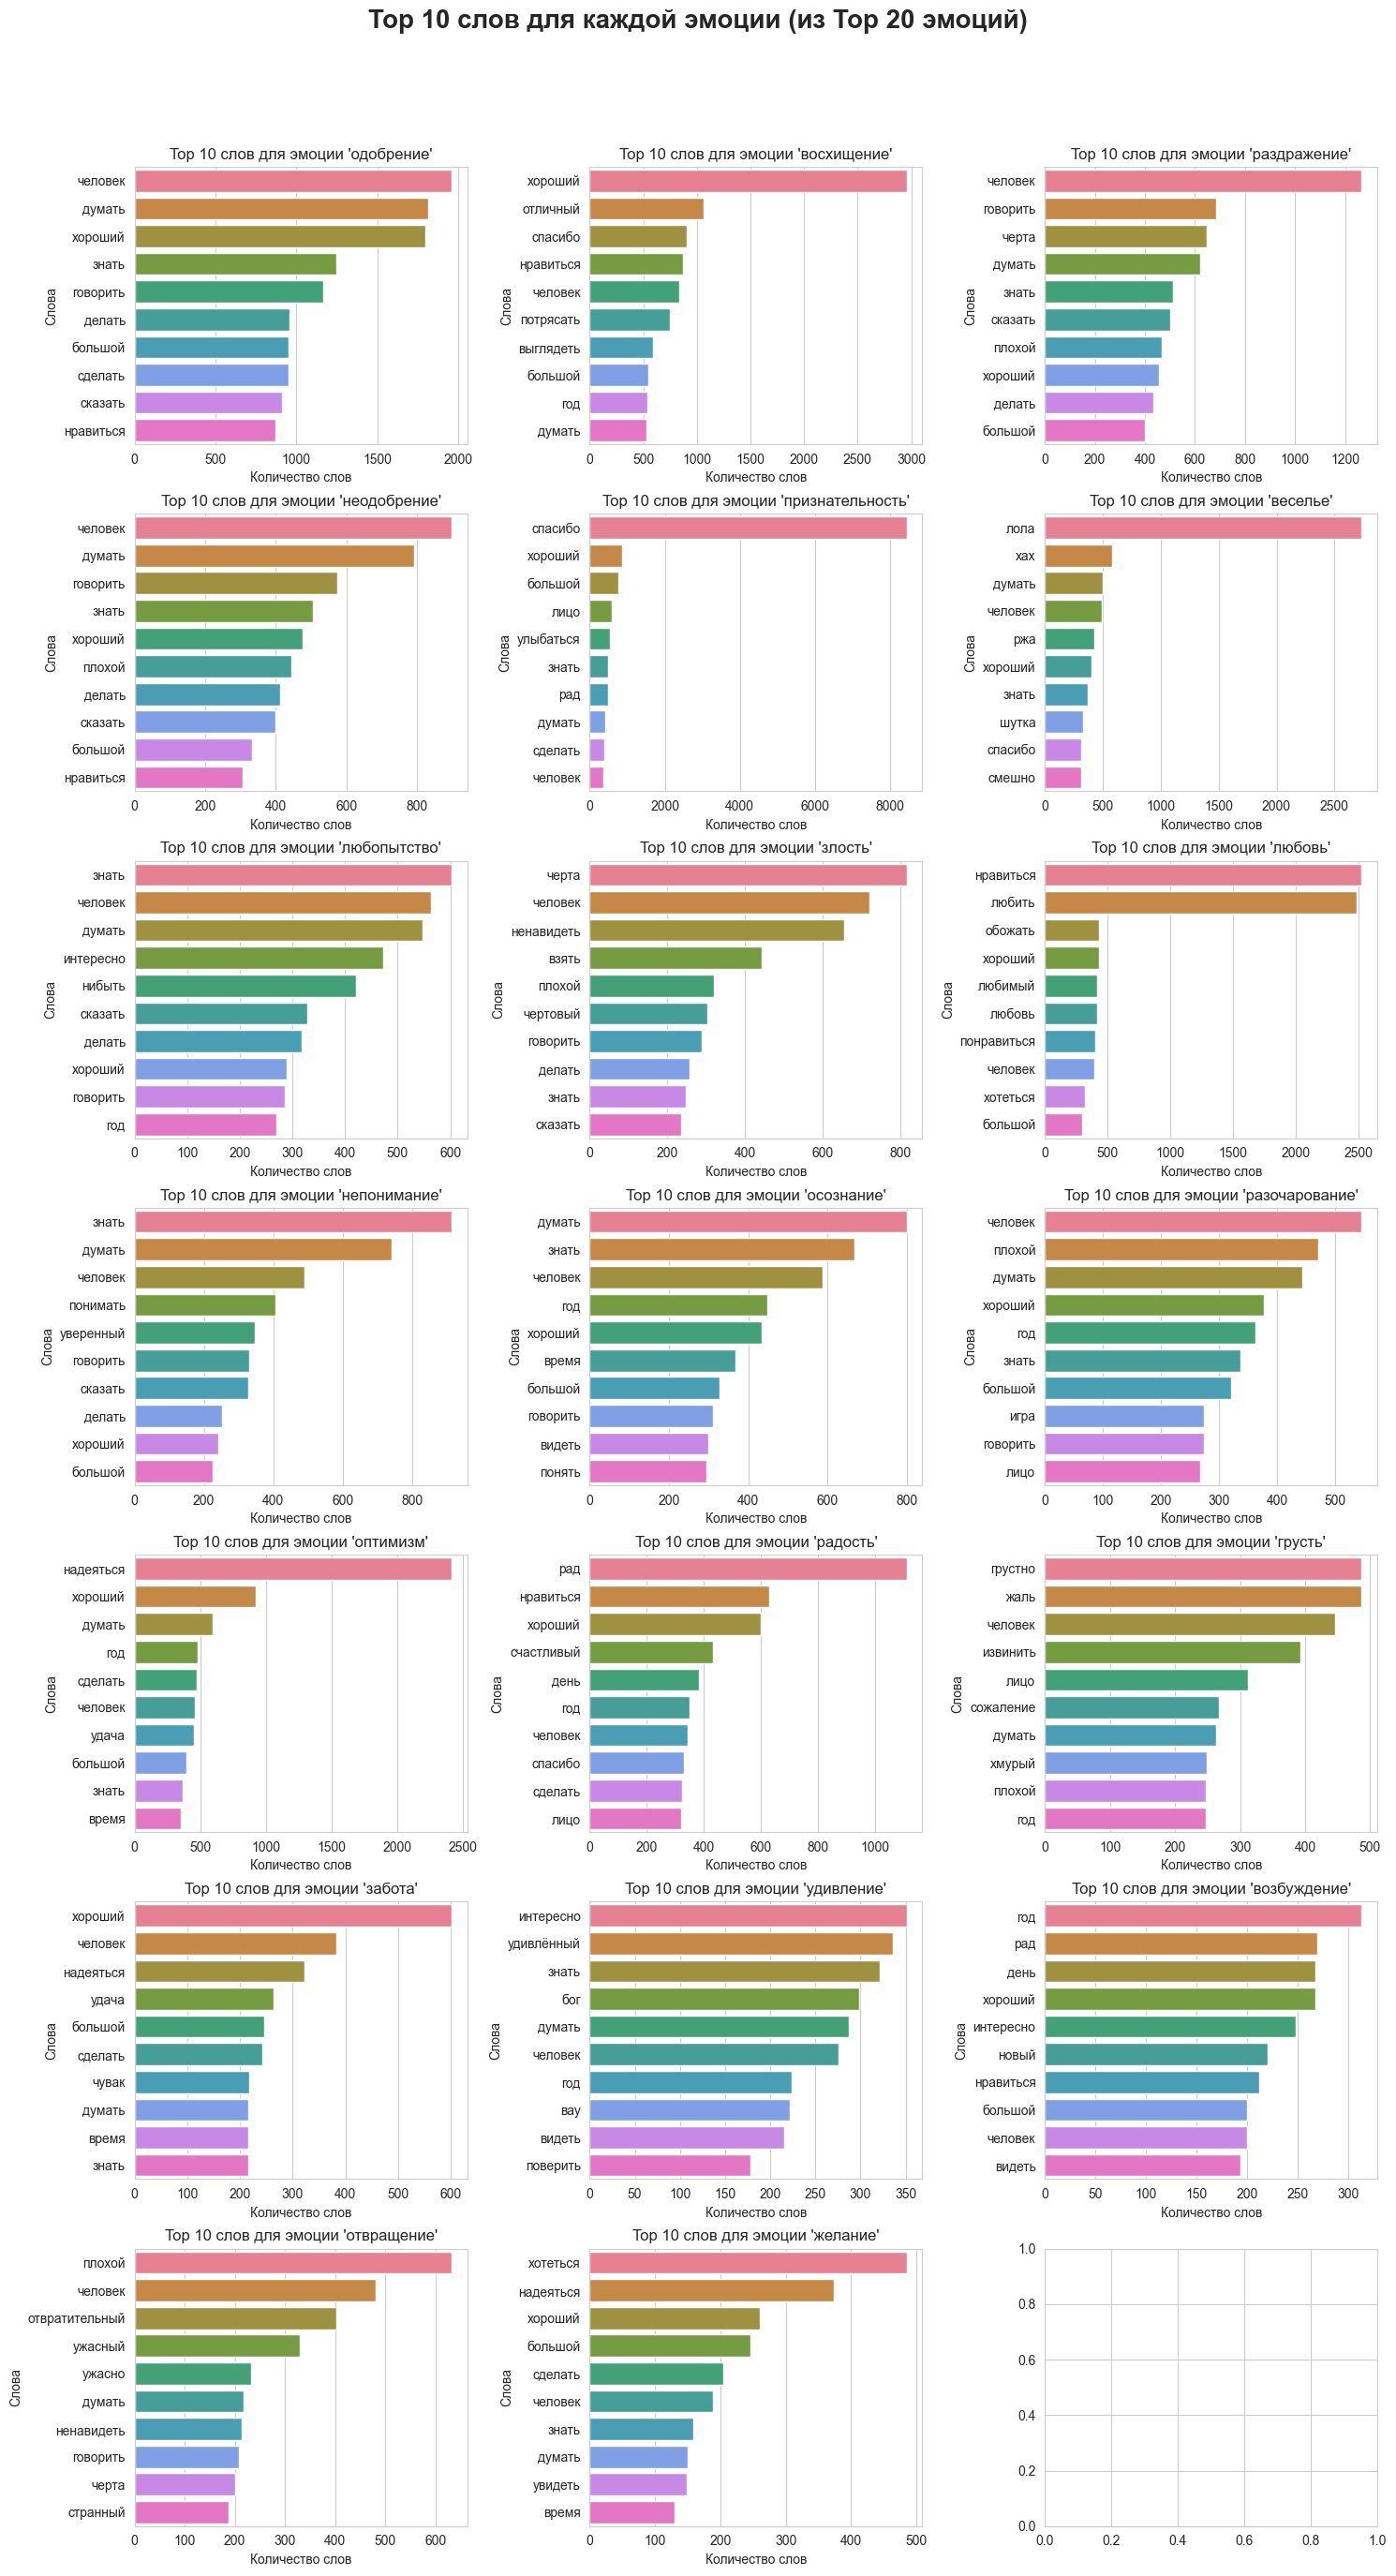

In [20]:
# Создание отдельных графиков для каждой эмоции из Top 20
num_rows = (len(emotion_counts) + 2) // 3  # Округление вверх для числа строк
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 4 * num_rows))
fig.suptitle('Top 10 слов для каждой эмоции (из Top 20 эмоций)', fontweight="bold", fontsize=20)

# Перебор по эмоциям и организация их в сетку 3xN
for idx, (emotion_name, _) in enumerate(emotion_counts.items()):
    row, col = divmod(idx, 3)
    emotion_name_en_list = [key for key, value in taxonomy.items() if value == emotion_name]
    emotion_name_en = emotion_name_en_list[0] if emotion_name_en_list else None
    if emotion_name_en is not None:
        top10_words_in_class(df_train.loc[df_train["labels"].apply(lambda x: emotion_name_en in x), "ru_text_clean"], axes[row, col], emotion_name)


plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

In [21]:
df_train.head()

ru_text  admiration  amusement  \
0                       Эта игра причинила мне боль.           0          0   
2  Ты правильно поступаешь, если тебе все равно, ...           0          0   
3                            Чувак, я обожаю Reddit.           0          0   
4  [ИМЯ] не было рядом с ними, он был рядом с «Со...           0          0   
5  Верно? Учитывая, что это такой важный документ...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      0          0         0       0          0          0       0  ...   
2      0          0         0       0          0          0       0  ...   
3      0          0         0       0          0          0       0  ...   
4      0          0         0       0          0          0       0  ...   
5      0          0         0       0          0          0       0  ...   

   optimism  pride  realization  relief  remorse  sadness  surprise  \
0         0      0            0       0        0        1         0   
2         0      0            0       0        0        0         0   
3         0      0            0       0        0        0         0   
4         0      0            0       0        0        0         0   
5         0      0            0       0        0        0         0   

      labels                                      ru_text_clean  \
0    sadness                                игра причинить боль   
2    neutral           правильно поступать всё равно идти черта   
3       love                               чувак обожать reddit   
4    neutral                                  рядом рядом сокол   
5  gratitude  верно учитывать это важный документ должный зн...   

         ru_labels  
0           грусть  
2    нейтральность  
3           любовь  
4    нейтральность  
5  признательность  

[5 rows x 31 columns]

In [22]:
df_train = df_train.drop('ru_text', axis=1).drop('labels', axis=1).drop('ru_labels', axis=1)
move_column = df_train.pop("ru_text_clean")
df_train.insert(0, "ru_text_clean", move_column)

display(df_train.sample(5))

print(df_train.shape)


ru_text_clean  admiration  \
53303   понять человек квартира суть облажаться это оч...           0   
55070   совершенно очевидный неправильно это прочитать...           0   
198512       круто новый вывеска появиться улыбаться лицо           0   
19991   каков это обыграть беззубик получить лишь парш...           0   
97216   посмотреть это шоу понять ругательство мотивир...           1   

        amusement  anger  annoyance  approval  caring  confusion  curiosity  \
53303           0      0          0         0       0          0          1   
55070           0      0          0         0       0          0          0   
198512          0      0          0         0       0          0          0   
19991           0      0          0         0       0          0          1   
97216           0      0          0         0       0          0          0   

        desire  ...  joy  love  nervousness  optimism  pride  realization  \
53303        0  ...    0     0            0         0      0            0   
55070        0  ...    0     0            0         0      0            0   
198512       0  ...    0     0            0         0      0            0   
19991        0  ...    0     0            0         0      0            0   
97216        0  ...    0     0            0         0      0            0   

        relief  remorse  sadness  surprise  
53303        0        0        1         0  
55070        0        0        0         0  
198512       0        0        0         0  
19991        0        0        0         0  
97216        0        0        0         0  

[5 rows x 28 columns]

(207814, 28)


In [23]:
# Удалим все строки, где эмоции не определены (содержат 0) после того как удалили столбец нейтральных эмоций
print(df_train.shape)
df_train = df_train.loc[ df_train.apply(lambda x: sum(x[1:]), axis=1)>0 ]
print(df_train.shape)

(207814, 28)
(152516, 28)


In [24]:
# Найти пустые строки
empty_strings = df_train[df_train['ru_text_clean'].astype(str).str.strip() == '']

# Найти строки с NaN
nan_values = df_train[df_train['ru_text_clean'].isna()]

# Объединить результаты
empty_or_nan_rows = pd.concat([empty_strings, nan_values])

# Вывести результаты
print("Пустые строки и NaN:")
print(empty_or_nan_rows)

Пустые строки и NaN:
       ru_text_clean  admiration  amusement  anger  annoyance  approval  \
210                            0          0      0          0         0   
1723                           0          0      0          0         0   
2196                           0          0      0          0         0   
2694                           0          0      0          0         0   
2879                           0          0      0          0         1   
...              ...         ...        ...    ...        ...       ...   
209876                         0          0      0          0         0   
210179                         0          0      0          0         0   
210433                         1          0      0          0         0   
210827                         0          0      0          0         0   
211192                         0          0      0          0         0   

        caring  confusion  curiosity  desire  ...  joy  love  nervousness  \
2

In [25]:
# Получить индексы найденных строк
rows_to_drop = empty_or_nan_rows.index

# Удалить строки из исходного DataFrame
df_train = df_train.drop(rows_to_drop)

In [26]:
# Проверим еще раз наличие пустышек
# Найти пустые строки
empty_strings = df_train[df_train['ru_text_clean'].astype(str).str.strip() == '']

# Найти строки с NaN
nan_values = df_train[df_train['ru_text_clean'].isna()]

# Объединить результаты
empty_or_nan_rows = pd.concat([empty_strings, nan_values])

# Вывести результаты
print("Пустые строки и NaN:")
print(empty_or_nan_rows)

Пустые строки и NaN:
Empty DataFrame
Columns: [ru_text_clean, admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise]
Index: []

[0 rows x 28 columns]


In [27]:
# Сохранение очищенных датасетов для создания и обучения моделей
df_train.to_csv("../datasets/raw_clean.csv", index = False)
